This all data and detail is from : https://www.kaggle.com/c/home-credit-default-risk/data

In [1]:
!pip install xgboost 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
import seaborn as sns
from google.colab import drive
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import BorderlineSMOTE


In [2]:
drive.mount('/content/gdrive')
path  = '/content/gdrive/MyDrive/Colab data source/Home Credit risk/'
pd.set_option('display.float_format', lambda x: '%.5f' % x)
train = pd.read_csv(path+'application_train.csv')
test = pd.read_csv(path+'application_test.csv')
bureau_balance = pd.read_csv(path+'bureau_balance.csv')
POS_balance= pd.read_csv(path+'POS_CASH_balance.csv')
prev_app= pd.read_csv(path+'previous_application.csv')
credit_card_bal = pd.read_csv(path+'credit_card_balance.csv')
install_payment = pd.read_csv(path+'installments_payments.csv')
bureau  =pd.read_csv(path + 'bureau.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Explore Data & Cleaning Data

In [4]:
def showna (df ):
  print('Full frame : '+ str(len(df)))
  cnt = 0 
  for (colname , coldata) in df.iteritems():
    
    lost_percentage =  (df[colname].isna().sum()/len(df))*100
    if(lost_percentage!= 0 ):
      cnt+=1
      print(colname +' : ' +str( df[colname].isna().sum()) +' loss as : '+ str(lost_percentage)+'%')
  print("cnt lost columns : "+ str(cnt))

In [5]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,351000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01880,-9461,-637,-3648.00000,-2120,nan,1,1,0,1,1,0,Laborers,1.00000,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.02050,0.01930,0.00000,0.00000,reg oper account,block of flats,0.01490,"Stone, brick",No,2.00000,2.00000,2.00000,2.00000,-1134.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,1129500.00000,Family,State servant,Higher education,Married,House / apartment,0.00354,-16765,-1188,-1186.00000,-291,nan,1,1,0,1,1,0,Core staff,2.00000,1,1,MONDAY,11,0,0,0,0,0,0,...,0.07870,0.05580,0.00390,0.01000,reg oper account,block of flats,0.07140,Block,No,1.00000,0.00000,1.00000,0.00000,-828.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,135000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01003,-19046,-225,-4260.00000,-2531,26.00000,1,1,1,1,1,0,Laborers,1.00000,2,2,MONDAY,9,0,0,0,0,0,0,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-815.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,297000.00000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.00802,-19005,-3039,-9833.00000,-2437,nan,1,1,0,1,0,0,Laborers,2.00000,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,2.00000,0.00000,2.00000,0.00000,-617.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,513000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02866,-19932,-3038,-4311.00000,-3458,nan,1,1,0,1,0,0,Core staff,1.00000,2,2,THURSDAY,11,0,0,0,0,1,1,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-1106.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [6]:
train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307499.00000,307233.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,104582.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307509.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,134133.00000,306851.00000,246546.00000,151450.00000,127568.00000,157504.00000,103023.00000,92646.00000,143620.00000,152683.00000,154491.00000,...,152683.00000,154491.00000,98869.00000,124921.00000,97312.00000,153161.00000,93997.00000,137829.00000,159080.00000,306490.00000,306490.00000,306490.00000,306490.00000,307510.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000
mean,278180.51858,0.08073,0.41705,168797.91930,599025.99971,27108.57391,538396.20743,0.02087,-16036.99507,63815.04590,-4986.12033,-2994.20237,12.06109,1.00000,0.81989,0.19937,0.99813,0.28107,0.05672,2.15267,2.05246,2.03152,12.06342,0.01514,0.05077,0.04066,0.07817,0.23045,0.17955,0.50213,0.51439,0.51085,0.11744,0.08844,0.97773,0.75247,0.04462,0.07894,0.14972,0.22628,...,0.14921,0.22590,0.23162,0.06717,0.10195,0.10861,0.00865,0.02824,0.10255,1.42225,0.14342,1.40529,0.10005,-962.85879,0.00004,0.71002,0.00008,0.01511,0.08806,0.00019,0.08138,0.00390,0.00002,0.00391,0.00001,0.00353,0.00294,0.00121,0.00993,0.00027,0.00813,0.00060,0.00051,0.00033,0.00640,0.00700,0.03436,0.26740,0.26547,1.89997
std,102790.17535,0.27242,0.72212,237123.14628,402490.77700,14493.73732,369446.46054,0.01383,4363.98863,141275.76652,3522.88632,1509.45042,11.94481,0.00180,0.38428,0.39953,0.04316,0.44952,0.23131,0.91068,0.50903,0.50274,3.26583,0.12213,0.21953,0.19750,0.26844,0.42112,0.38382,0.21106,0.19106,0.19484,0.10824,0.08244,0.05922,0.11328,0.07604,0.13458,0.10005,0.14464,...,0.10037,0.14507,0.16193,0.08217,0.09364,0.11226,0.04741,0.07017,0.10746,2.40099,0.44670,2.37980,0.36229,826.80849,0.00650,0.45375,0.00902,0.12201,0.28338,0.01385,0.27341,0.06229,0.00477,0.06242,0.00255,0.05927,0.05411,0.03476,0.09914,0.01633,0.08980,0.02439,0.02252,0.01830,0.08385,0.11076,0.20468,0.91600,0.79406,1.86929
min,100002.00000,0.00000,0.00000,25650.00000,45000.00000,1615.50000,40500.00000,0.00029,-25229.00000,-17912.00000,-2

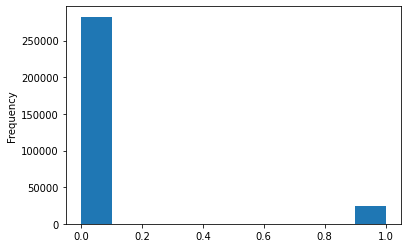

In [7]:
train['TARGET'].plot.hist()

from above graph we can see the problem we call imbalance dataset , May be we have to resample it or may be try some model that great with imbalance dataset such as random forest. I won't decide it now let take a look further.

In [8]:
showna(train)

Full frame : 307511
AMT_ANNUITY : 12 loss as : 0.003902299429939092%
AMT_GOODS_PRICE : 278 loss as : 0.09040327012692229%
NAME_TYPE_SUITE : 1292 loss as : 0.42014757195677555%
OWN_CAR_AGE : 202929 loss as : 65.9908100848425%
OCCUPATION_TYPE : 96391 loss as : 31.345545362604916%
CNT_FAM_MEMBERS : 2 loss as : 0.0006503832383231819%
EXT_SOURCE_1 : 173378 loss as : 56.381072546998325%
EXT_SOURCE_2 : 660 loss as : 0.21462646864665005%
EXT_SOURCE_3 : 60965 loss as : 19.825307062186393%
APARTMENTS_AVG : 156061 loss as : 50.74972927797705%
BASEMENTAREA_AVG : 179943 loss as : 58.51595552679416%
YEARS_BEGINEXPLUATATION_AVG : 150007 loss as : 48.781019215572776%
YEARS_BUILD_AVG : 204488 loss as : 66.49778381911543%
COMMONAREA_AVG : 214865 loss as : 69.87229725115525%
ELEVATORS_AVG : 163891 loss as : 53.29597965601231%
ENTRANCES_AVG : 154828 loss as : 50.3487680115508%
FLOORSMAX_AVG : 153020 loss as : 49.76082156410665%
FLOORSMIN_AVG : 208642 loss as : 67.84862980511267%
LANDAREA_AVG : 182590 loss

We saw that there a lot of null value in dataframe so  we have to deal with it we can't drop these all because there a lot of missing vaues may be we have to impute   data or  use some special ML such as XGboost that can handle these missing value but I won't decide that now let take a look for other factors .

Let's check type of each columns is if it tell us something . 

In [9]:
train.dtypes

SK_ID_CURR                      int64
TARGET                          int64
NAME_CONTRACT_TYPE             object
CODE_GENDER                    object
FLAG_OWN_CAR                   object
                               ...   
AMT_REQ_CREDIT_BUREAU_DAY     float64
AMT_REQ_CREDIT_BUREAU_WEEK    float64
AMT_REQ_CREDIT_BUREAU_MON     float64
AMT_REQ_CREDIT_BUREAU_QRT     float64
AMT_REQ_CREDIT_BUREAU_YEAR    float64
Length: 122, dtype: object

In [10]:
train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [11]:
train.select_dtypes('object').apply(pd.Series.nunique,axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

In [12]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,351000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01880,-9461,-637,-3648.00000,-2120,nan,1,1,0,1,1,0,Laborers,1.00000,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.02050,0.01930,0.00000,0.00000,reg oper account,block of flats,0.01490,"Stone, brick",No,2.00000,2.00000,2.00000,2.00000,-1134.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,1129500.00000,Family,State servant,Higher education,Married,House / apartment,0.00354,-16765,-1188,-1186.00000,-291,nan,1,1,0,1,1,0,Core staff,2.00000,1,1,MONDAY,11,0,0,0,0,0,0,...,0.07870,0.05580,0.00390,0.01000,reg oper account,block of flats,0.07140,Block,No,1.00000,0.00000,1.00000,0.00000,-828.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,135000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01003,-19046,-225,-4260.00000,-2531,26.00000,1,1,1,1,1,0,Laborers,1.00000,2,2,MONDAY,9,0,0,0,0,0,0,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-815.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,297000.00000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.00802,-19005,-3039,-9833.00000,-2437,nan,1,1,0,1,0,0,Laborers,2.00000,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,2.00000,0.00000,2.00000,0.00000,-617.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,513000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02866,-19932,-3038,-4311.00000,-3458,nan,1,1,0,1,0,0,Core staff,1.00000,2,2,THURSDAY,11,0,0,0,0,1,1,...,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-1106.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [13]:
train = train.replace('XNA',np.nan)
test = test.replace('XNA',np.nan)

There are a lot of category value we will have to encoding it later , due to a lot of type per  column  one-hot encoding will make it a larger dataframe but if we use label encoding it's not good because it will value one type over another without reasonable reason so I will decide to use one-hot encoding if it has too many dimension  I'll reduce dimension later  may be using PCA or other  features selection method.

In [14]:
# print(train.shape , test.shape)
# target =  train['TARGET']
# train.drop(columns = 'TARGET',axis =1 ,inplace = True)
# train =  pd.get_dummies(train)
# test =  pd.get_dummies(test)
# train , test =  train.align(test,join = 'inner',axis  =1)
# train['TARGET'] =  target
# print(train.shape , test.shape)



Let's check anomalies and outliers. 

In [15]:
train.describe()


,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307499.00000,307233.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,104582.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307509.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,134133.00000,306851.00000,246546.00000,151450.00000,127568.00000,157504.00000,103023.00000,92646.00000,143620.00000,152683.00000,154491.00000,...,152683.00000,154491.00000,98869.00000,124921.00000,97312.00000,153161.00000,93997.00000,137829.00000,159080.00000,306490.00000,306490.00000,306490.00000,306490.00000,307510.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,307511.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000,265992.00000
mean,278180.51858,0.08073,0.41705,168797.91930,599025.99971,27108.57391,538396.20743,0.02087,-16036.99507,63815.04590,-4986.12033,-2994.20237,12.06109,1.00000,0.81989,0.19937,0.99813,0.28107,0.05672,2.15267,2.05246,2.03152,12.06342,0.01514,0.05077,0.04066,0.07817,0.23045,0.17955,0.50213,0.51439,0.51085,0.11744,0.08844,0.97773,0.75247,0.04462,0.07894,0.14972,0.22628,...,0.14921,0.22590,0.23162,0.06717,0.10195,0.10861,0.00865,0.02824,0.10255,1.42225,0.14342,1.40529,0.10005,-962.85879,0.00004,0.71002,0.00008,0.01511,0.08806,0.00019,0.08138,0.00390,0.00002,0.00391,0.00001,0.00353,0.00294,0.00121,0.00993,0.00027,0.00813,0.00060,0.00051,0.00033,0.00640,0.00700,0.03436,0.26740,0.26547,1.89997
std,102790.17535,0.27242,0.72212,237123.14628,402490.77700,14493.73732,369446.46054,0.01383,4363.98863,141275.76652,3522.88632,1509.45042,11.94481,0.00180,0.38428,0.39953,0.04316,0.44952,0.23131,0.91068,0.50903,0.50274,3.26583,0.12213,0.21953,0.19750,0.26844,0.42112,0.38382,0.21106,0.19106,0.19484,0.10824,0.08244,0.05922,0.11328,0.07604,0.13458,0.10005,0.14464,...,0.10037,0.14507,0.16193,0.08217,0.09364,0.11226,0.04741,0.07017,0.10746,2.40099,0.44670,2.37980,0.36229,826.80849,0.00650,0.45375,0.00902,0.12201,0.28338,0.01385,0.27341,0.06229,0.00477,0.06242,0.00255,0.05927,0.05411,0.03476,0.09914,0.01633,0.08980,0.02439,0.02252,0.01830,0.08385,0.11076,0.20468,0.91600,0.79406,1.86929
min,100002.00000,0.00000,0.00000,25650.00000,45000.00000,1615.50000,40500.00000,0.00029,-25229.00000,-17912.00000,-2

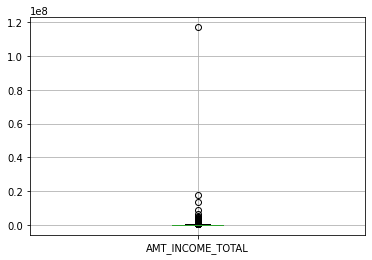

In [16]:
train.boxplot(column ='AMT_INCOME_TOTAL')

The max value is very very extreme outlier so we will drop it.

In [17]:
train  = train.drop(train[train['AMT_INCOME_TOTAL']== train['AMT_INCOME_TOTAL'].max()].index)

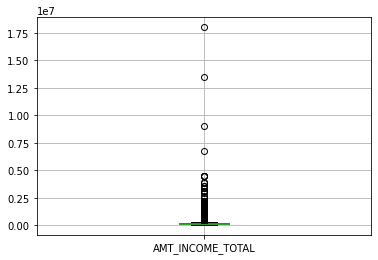

In [18]:
train.boxplot(column = 'AMT_INCOME_TOTAL')

It's look better . 

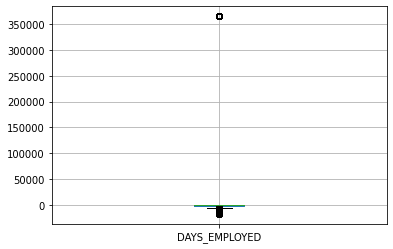

In [19]:
train.boxplot(column = 'DAYS_EMPLOYED')

The days employ should be negative (relate to application date) so this row has a chance to be anomalies data and we'll drop it. 

In [20]:
train  = train.drop(train[train['DAYS_EMPLOYED']== train['DAYS_EMPLOYED'].max()].index)

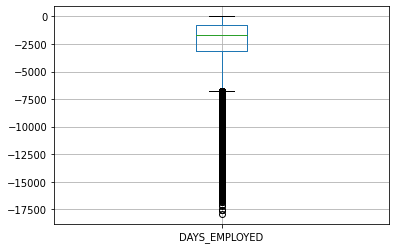

In [21]:
train.boxplot(column = 'DAYS_EMPLOYED')

In [22]:
train['Age']= train['DAYS_BIRTH']/-365
test['Age']= test['DAYS_BIRTH']/-365
train['Work_year'] =  train['DAYS_EMPLOYED']/-365
test['Work_year'] =  test['DAYS_EMPLOYED']/-365

My hypothesis is age  and work year has correlation with default risk let's visualize it first .

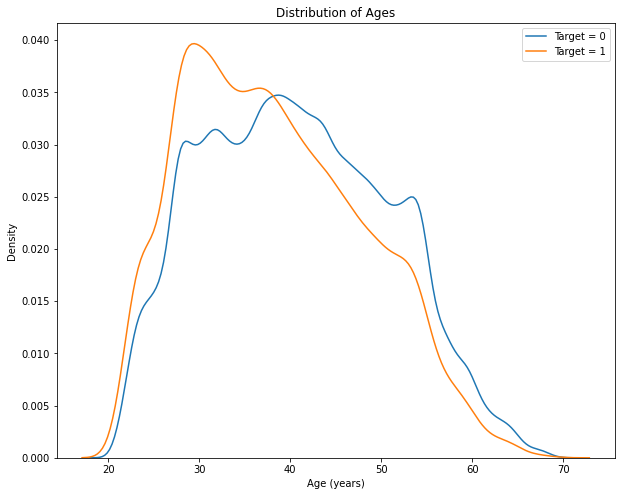

In [23]:
plt.figure(figsize=(10,8))
sns.kdeplot(train.loc[train['TARGET']==0,'Age'],label  = 'Target = 0')
sns.kdeplot(train.loc[train['TARGET']==1,'Age'],label  = 'Target = 1')
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');
plt.legend(loc =  'upper right')

this graph show that younger age has more rate to defualt credit .
but let's go more specific which age range . 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


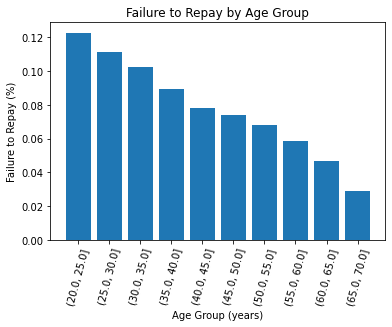

In [24]:
age_bin  = train[['TARGET','Age']]
age_bin['bin'] =  pd.cut(age_bin['Age'],bins = np.linspace(20,70,num =11))
age_bin.head()
grouped_age = age_bin.groupby('bin').mean()

plt.bar(grouped_age.index.astype(str), grouped_age['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

'Age' column may be helpful in model .  Next let's test 'Work year' 

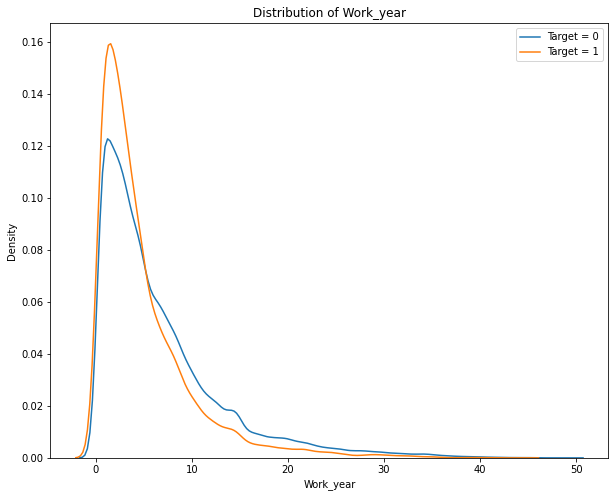

In [25]:
plt.figure(figsize=(10,8))
sns.kdeplot(train.loc[train['TARGET']==0,'Work_year'],label  = 'Target = 0')
sns.kdeplot(train.loc[train['TARGET']==1,'Work_year'],label  = 'Target = 1')
plt.xlabel('Work_year'); plt.ylabel('Density'); plt.title('Distribution of Work_year');
plt.legend(loc =  'upper right')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


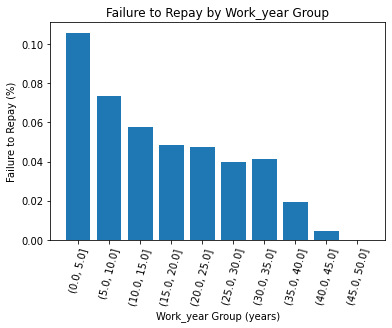

In [26]:
worked_bin  = train[['TARGET','Work_year']]
worked_bin['bin'] =  pd.cut(worked_bin['Work_year'],bins = np.linspace(0,50,num =11))
worked_bin.head()
grouped_worked = worked_bin.groupby('bin').mean()
plt.bar(grouped_worked.index.astype(str), grouped_worked['TARGET'])
plt.xticks(rotation = 75); plt.xlabel('Work_year Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Work_year Group');

This show that the less 'Work_year' the more risk to default . this features may be useful in model , keep it .

Test Correlation with Target

In [27]:
correlation = train.corr()['TARGET'].sort_values(ascending  = False,key =abs)
correlation.head(15)

TARGET                         1.00000
EXT_SOURCE_3                  -0.17974
EXT_SOURCE_2                  -0.17051
EXT_SOURCE_1                  -0.15535
Work_year                     -0.07495
DAYS_EMPLOYED                  0.07495
REGION_RATING_CLIENT_W_CITY    0.06746
Age                           -0.06575
DAYS_BIRTH                     0.06575
REGION_RATING_CLIENT           0.06512
DAYS_LAST_PHONE_CHANGE         0.06027
AMT_GOODS_PRICE               -0.05034
FLOORSMAX_AVG                 -0.04946
FLOORSMAX_MEDI                -0.04915
FLOORSMAX_MODE                -0.04855
Name: TARGET, dtype: float64

Note that  the correlation is not the best tool of usefullness of features but we still need to see what each features corelate to target value 

# Features Engineering

In [28]:
target = train['TARGET']

To transform polynomialit use a lot of computatioan cost so  I will limit features up to 10  I will select top 10 by correlation.

In [29]:
features_for_poly  = correlation[1:10].index.to_list()
poly_features_train = train[features_for_poly]
poly_features_test = test[features_for_poly]
imputer = SimpleImputer(strategy = 'median') # due to we have many outlier mean is not a good choice.
poly_features_train= imputer.fit_transform(poly_features_train)
poly_features_test= imputer.fit_transform(poly_features_test)
transformer =  PolynomialFeatures(degree= 3)
transformer.fit(poly_features_train)
poly_features_train = transformer.transform(poly_features_train)
poly_features_test = transformer.transform(poly_features_test)
# convert these to data frame 
poly_features_train  =  pd.DataFrame(poly_features_train, columns = transformer.get_feature_names(input_features=features_for_poly))
poly_features_train['TARGET'] = target

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
poly_corr = poly_features_train.corr()['TARGET'].sort_values(ascending  = False,key =abs)
poly_corr.head(15)

TARGET                                                   1.00000
EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT           0.00389
EXT_SOURCE_3 EXT_SOURCE_1                                0.00377
EXT_SOURCE_3 EXT_SOURCE_1 Age                            0.00366
EXT_SOURCE_3 EXT_SOURCE_1 DAYS_BIRTH                    -0.00366
EXT_SOURCE_3^2 EXT_SOURCE_1                              0.00346
EXT_SOURCE_3 DAYS_BIRTH^2                                0.00333
EXT_SOURCE_3 Age DAYS_BIRTH                             -0.00333
EXT_SOURCE_3 Age^2                                       0.00333
EXT_SOURCE_3 EXT_SOURCE_1 REGION_RATING_CLIENT_W_CITY    0.00331
EXT_SOURCE_3 Age                                         0.00326
EXT_SOURCE_3 DAYS_BIRTH                                 -0.00326
EXT_SOURCE_3 DAYS_BIRTH REGION_RATING_CLIENT            -0.00323
EXT_SOURCE_3 Age REGION_RATING_CLIENT                    0.00323
EXT_SOURCE_3 EXT_SOURCE_1^2                              0.00316
Name: TARGET, dtype: floa

The polynomial is still not a good choice for this  may be Domain knowledge feature may help as you see from very low correlation so we will find another way may be features from domain knowledge help.

Disclamer : I'm not financial expert so I research this from internet thank for  [this script](https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features?scriptVersionId=6025993) by Aguiar
So we'll create these features from domain knowledge  : CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income

-ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income

-CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due

-DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age

In [31]:
def createDomainFeatures (app_train_domain):
  app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
  app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
  app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
  app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']
  return app_train_domain

In [32]:
train = createDomainFeatures(train)
test =  createDomainFeatures(test)

In [33]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,Work_year,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100002,1,Cash loans,M,N,Y,0,202500.00000,406597.50000,24700.50000,351000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01880,-9461,-637,-3648.00000,-2120,nan,1,1,0,1,1,0,Laborers,1.00000,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.01490,"Stone, brick",No,2.00000,2.00000,2.00000,2.00000,-1134.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,25.92055,1.74521,2.00789,0.12198,0.06075,0.06733
1,100003,0,Cash loans,F,N,N,0,270000.00000,1293502.50000,35698.50000,1129500.00000,Family,State servant,Higher education,Married,House / apartment,0.00354,-16765,-1188,-1186.00000,-291,nan,1,1,0,1,1,0,Core staff,2.00000,1,1,MONDAY,11,0,0,0,0,0,0,...,0.07140,Block,No,1.00000,0.00000,1.00000,0.00000,-828.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,45.93151,3.25479,4.79075,0.13222,0.02760,0.07086
2,100004,0,Revolving loans,M,Y,Y,0,67500.00000,135000.00000,6750.00000,135000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.01003,-19046,-225,-4260.00000,-2531,26.00000,1,1,1,1,1,0,Laborers,1.00000,2,2,MONDAY,9,0,0,0,0,0,0,...,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-815.00000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,52.18082,0.61644,2.00000,0.10000,0.05000,0.01181
3,100006,0,Cash loans,F,N,Y,0,135000.00000,312682.50000,29686.50000,297000.00000,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.00802,-19005,-3039,-9833.00000,-2437,nan,1,1,0,1,0,0,Laborers,2.00000,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,nan,NaN,NaN,2.00000,0.00000,2.00000,0.00000,-617.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan,52.06849,8.32603,2.31617,0.21990,0.09494,0.15991
4,100007,0,Cash loans,M,N,Y,0,121500.00000,513000.00000,21865.50000,513000.00000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.02866,-19932,-3038,-4311.00000,-3458,nan,1,1,0,1,0,0,Core staff,1.00000,2,2,THURSDAY,11,0,0,0,0,1,1,...,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-1106.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,54.60822,8.32329,4.22222,0.17996,0.04262,0.15242


In [34]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,...,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,Age,Work_year,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
0,100001,Cash loans,F,N,Y,0,135000.00000,568800.00000,20560.50000,450000.00000,Unaccompanied,Working,Higher education,Married,House / apartment,0.01885,-19241,-2329,-5170.00000,-812,nan,1,1,0,1,0,1,NaN,2.00000,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,...,0.03920,"Stone, brick",No,0.00000,0.00000,0.00000,0.00000,-1740.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,52.71507,6.38082,4.21333,0.15230,0.03615,0.12104
1,100005,Cash loans,M,N,Y,0,99000.00000,222768.00000,17370.00000,180000.00000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.03579,-18064,-4469,-9118.00000,-1623,nan,1,1,0,1,0,0,Low-skill Laborers,2.00000,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,...,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,0.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,49.49041,12.24384,2.25018,0.17545,0.07797,0.24740
2,100013,Cash loans,M,Y,Y,0,202500.00000,663264.00000,69777.00000,630000.00000,NaN,Working,Higher education,Married,House / apartment,0.01910,-20038,-4458,-2175.00000,-3503,5.00000,1,1,0,1,0,0,Drivers,2.00000,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,...,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-856.00000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,1.00000,4.00000,54.89863,12.21370,3.27538,0.34458,0.10520,0.22248
3,100028,Cash loans,F,N,Y,2,315000.00000,1575000.00000,49018.50000,1575000.00000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.02639,-13976,-1866,-2000.00000,-4208,nan,1,1,0,1,1,0,Sales staff,4.00000,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,...,0.37000,Panel,No,0.00000,0.00000,0.00000,0.00000,-1805.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00000,0.00000,0.00000,0.00000,0.00000,3.00000,38.29041,5.11233,5.00000,0.15561,0.03112,0.13351
4,100038,Cash loans,M,Y,N,1,180000.00000,625500.00000,32067.00000,625500.00000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.01003,-13040,-2191,-4000.00000,-4262,16.00000,1,1,1,1,0,0,NaN,3.00000,2,2,FRIDAY,5,0,0,0,0,1,1,Business Entity Type 3,...,nan,NaN,NaN,0.00000,0.00000,0.00000,0.00000,-821.00000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,nan,nan,35.72603,6.00274,3.47500,0.17815,0.05127,0.16802


In [35]:
print('Train Shape : {}'.format(train.shape))
print('Test Shape : {}'.format(test.shape))


Train Shape : (252136, 128)
Test Shape : (48744, 127)


Next we need more features form additional table . 

In [36]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00000,-153.00000,nan,0,91323.00000,0.00000,nan,0.00000,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,1075.00000,nan,nan,0,225000.00000,171342.00000,nan,0.00000,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.00000,nan,nan,0,464323.50000,nan,nan,0.00000,Consumer credit,-16,nan
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,90000.00000,nan,nan,0.00000,Credit card,-16,nan
4,215354,5714466,Active,currency 1,-629,0,1197.00000,nan,77674.50000,0,2700000.00000,nan,nan,0.00000,Consumer credit,-21,nan


In [37]:
#each customer loan count  
loan_count =  bureau.groupby('SK_ID_CURR',as_index= False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU':'previous_loan_counts'})
loan_count.head()

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [38]:
# train = train.merge(loan_count, on = 'SK_ID_CURR', how = 'left')
# train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
# train.head()

see that each customer has more than one previous loan so that next step we will make stats calculatoin function to calculate stats for each customer (mean , max,sum , count .sum) 

ref : https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering#Putting-the-Functions-Together

In [39]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.
    
    Parameters
    --------
        df (dataframe): 
            the dataframe to calculate the statistics on
        group_var (string): 
            the variable by which to group df
        df_name (string): 
            the variable used to rename the columns
        
    Return
    --------
        agg (dataframe): 
            a dataframe with the statistics aggregated for 
            all numeric columns. Each instance of the grouping variable will have 
            the statistics (mean, min, max, sum; currently supported) calculated. 
            The columns are also renamed to keep track of features created.
    
    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [40]:
bureau_stats =  agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']),group_var =  'SK_ID_CURR',df_name = 'bureau')
bureau_stats.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,bureau_CREDIT_DAY_OVERDUE_sum,bureau_DAYS_CREDIT_ENDDATE_count,bureau_DAYS_CREDIT_ENDDATE_mean,bureau_DAYS_CREDIT_ENDDATE_max,bureau_DAYS_CREDIT_ENDDATE_min,bureau_DAYS_CREDIT_ENDDATE_sum,bureau_DAYS_ENDDATE_FACT_count,bureau_DAYS_ENDDATE_FACT_mean,bureau_DAYS_ENDDATE_FACT_max,bureau_DAYS_ENDDATE_FACT_min,bureau_DAYS_ENDDATE_FACT_sum,bureau_AMT_CREDIT_MAX_OVERDUE_count,bureau_AMT_CREDIT_MAX_OVERDUE_mean,bureau_AMT_CREDIT_MAX_OVERDUE_max,bureau_AMT_CREDIT_MAX_OVERDUE_min,bureau_AMT_CREDIT_MAX_OVERDUE_sum,bureau_CNT_CREDIT_PROLONG_count,bureau_CNT_CREDIT_PROLONG_mean,bureau_CNT_CREDIT_PROLONG_max,bureau_CNT_CREDIT_PROLONG_min,bureau_CNT_CREDIT_PROLONG_sum,bureau_AMT_CREDIT_SUM_count,bureau_AMT_CREDIT_SUM_mean,bureau_AMT_CREDIT_SUM_max,bureau_AMT_CREDIT_SUM_min,bureau_AMT_CREDIT_SUM_sum,bureau_AMT_CREDIT_SUM_DEBT_count,bureau_AMT_CREDIT_SUM_DEBT_mean,bureau_AMT_CREDIT_SUM_DEBT_max,bureau_AMT_CREDIT_SUM_DEBT_min,bureau_AMT_CREDIT_SUM_DEBT_sum,bureau_AMT_CREDIT_SUM_LIMIT_count,bureau_AMT_CREDIT_SUM_LIMIT_mean,bureau_AMT_CREDIT_SUM_LIMIT_max,bureau_AMT_CREDIT_SUM_LIMIT_min,bureau_AMT_CREDIT_SUM_LIMIT_sum,bureau_AMT_CREDIT_SUM_OVERDUE_count,bureau_AMT_CREDIT_SUM_OVERDUE_mean,bureau_AMT_CREDIT_SUM_OVERDUE_max,bureau_AMT_CREDIT_SUM_OVERDUE_min,bureau_AMT_CREDIT_SUM_OVERDUE_sum,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.00000,-49,-1572,-5145,7,0.00000,0,0,0,7,82.42857,1778.00000,-1329.00000,577.00000,4,-825.50000,-544.00000,-1328.00000,-3302.00000,0,nan,nan,nan,0.00000,7,0.00000,0,0,0,7,207623.57143,378000.00000,85500.00000,1453365.00000,7,85240.92857,373239.00000,0.00000,596686.50000,6,0.00000,0.00000,0.00000,0.00000,7,0.00000,0.00000,0.00000,0.00000,7,-93.14286,-6,-155,-652,7,3545.35714,10822.50000,0.00000,24817.50000
1,100002,8,-874.00000,-103,-1437,-6992,8,0.00000,0,0,0,6,-349.00000,780.00000,-1072.00000,-2094.00000,6,-697.50000,-36.00000,-1185.00000,-4185.00000,5,1681.02900,5043.64500,0.00000,8405.14500,8,0.00000,0,0,0,8,108131.94562,450000.00000,0.00000,865055.56500,5,49156.20000,245781.00000,0.00000,245781.00000,4,7997.14125,31988.56500,0.00000,31988.56500,8,0.00000,0.00000,0.00000,0.00000,8,-499.87500,-7,-1185,-3999,7,0.00000,0.00000,0.00000,0.00000
2,100003,4,-1400.75000,-606,-2586,-5603,4,0.00000,0,0,0,4,-544.50000,1216.00000,-2434.00000,-2178.00000,3,-1097.33333,-540.00000,-2131.00000,-3292.00000,4,0.00000,0.00000,0.00000,0.00000,4,0.00000,0,0,0,4,254350.12500,810000.00000,22248.00000,1017400.50000,4,0.00000,0.00000,0.00000,0.00000,4,202500.00000,810000.00000,0.00000,810000.00000,4,0.00000,0.00000,0.00000,0.00000,4,-816.00000,-43,-2131,-3264,0,nan,nan,nan,0.00000
3,100004,2,-867.00000,-408,-1326,-1734,2,0.00000,0,0,0,2,-488.50000,-382.00000,-595.00000,-977.00000,2,-532.50000,-382.00000,-683.00000,-1065.00000,1,0.00000,0.00000,0.00000,0.00000,2,0.00000,0,0,0,2,94518.90000,94537.80000,94500.00000,189037.80000,2,0.00000,0.00000,0.00000,0.00000,2,0.00000,0.00000,0.00000,0.00000,2,0.00000,0.00000,0.00000,0.00000,2,-532.00000,-382,-682,-1064,0,nan,nan,nan,0.00000
4,100005,3,-190.66667,-62,-373,-572,3,0.00000,0,0,0,3,439.33333,1324.00000,-128.00000,1318.00000,1,-123.00000,-123.00000,-123.00000,-123.00000,1,0.00000,0.00000,0.00000,0.00000,3,0.00000,0,0,0,3,219042.00000,568800.00000,29826.00000,657126.00000,3,189469.50000,543087.00000,0.00000,568408.50000,3,0.00000,0.00000,0.00000,0.00000,3,0.00000,0.00000,0.00000,0.00000,3,-54.33333,-11,-121,-163,3,1420.50000,4261.50000,0.00000,4261.50000


In [41]:
#train = train.merge(bureau_stats, on = 'SK_ID_CURR', how = 'left')

next we will create category handle function that calculate counts  & normalize each category for all category varibles.

In [42]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable
    
    Parameters
    --------
    df : dataframe 
        The dataframe to calculate the value counts for.
        
    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row
        
    df_name : string
        Variable added to the front of column names to keep track of columns

    
    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [43]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,bureau_CREDIT_CURRENCY_currency 2_count,bureau_CREDIT_CURRENCY_currency 2_count_norm,bureau_CREDIT_CURRENCY_currency 3_count,bureau_CREDIT_CURRENCY_currency 3_count_norm,bureau_CREDIT_CURRENCY_currency 4_count,bureau_CREDIT_CURRENCY_currency 4_count_norm,bureau_CREDIT_TYPE_Another type of loan_count,bureau_CREDIT_TYPE_Another type of loan_count_norm,bureau_CREDIT_TYPE_Car loan_count,bureau_CREDIT_TYPE_Car loan_count_norm,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count,bureau_CREDIT_TYPE_Cash loan (non-earmarked)_count_norm,bureau_CREDIT_TYPE_Consumer credit_count,bureau_CREDIT_TYPE_Consumer credit_count_norm,bureau_CREDIT_TYPE_Credit card_count,bureau_CREDIT_TYPE_Credit card_count_norm,bureau_CREDIT_TYPE_Interbank credit_count,bureau_CREDIT_TYPE_Interbank credit_count_norm,bureau_CREDIT_TYPE_Loan for business development_count,bureau_CREDIT_TYPE_Loan for business development_count_norm,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count,bureau_CREDIT_TYPE_Loan for purchase of shares (margin lending)_count_norm,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count,bureau_CREDIT_TYPE_Loan for the purchase of equipment_count_norm,bureau_CREDIT_TYPE_Loan for working capital replenishment_count,bureau_CREDIT_TYPE_Loan for working capital replenishment_count_norm,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100001,3,0.42857,0,0.00000,4,0.57143,0,0.00000,7,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,7,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000
100002,2,0.25000,0,0.00000,6,0.75000,0,0.00000,8,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,4,0.50000,4,0.50000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000
100003,1,0.25000,0,0.00000,3,0.75000,0,0.00000,4,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,2,0.50000,2,0.50000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000
100004,0,0.00000,0,0.00000,2,1.00000,0,0.00000,2,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,2,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000
100005,2,0.66667,0,0.00000,1,0.33333,0,0.00000,3,1.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,2,0.66667,1,0.33333,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000


In [44]:
# train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
# train.head()

Next for  bureau balance we will :

1.Calculated numeric stats grouping by each loan

2.
Made value counts of each categorical variable grouping by loan

3.Merged the stats and the value counts on the loans

4.Calculated numeric stats for the resulting dataframe grouping by the client id

In [45]:
bureau_balance_counts = count_categorical(bureau_balance,group_var= 'SK_ID_BUREAU',df_name= 'bureau_balance')
bureau_balance_stats = agg_numeric(bureau_balance,group_var= 'SK_ID_BUREAU',df_name= 'bureau_balance')
bureau_balance_counts.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,86,0.88660,11,0.11340
5001710,5,0.06024,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,48,0.57831,30,0.36145
5001711,3,0.75000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,1,0.25000
5001712,10,0.52632,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,9,0.47368,0,0.00000
5001713,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,22,1.00000


In [46]:
bureau_balance_stats.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.00000,0,-96,-4656
1,5001710,83,-41.00000,0,-82,-3403
2,5001711,4,-1.50000,0,-3,-6
3,5001712,19,-9.00000,0,-18,-171
4,5001713,22,-10.50000,0,-21,-231


In [47]:
bureau_by_loan = bureau_balance_stats.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')
bureau_by_loan.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm,SK_ID_CURR
0,5001709,97,-48.00000,0,-96,-4656,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,86,0.88660,11,0.11340,nan
1,5001710,83,-41.00000,0,-82,-3403,5,0.06024,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,48,0.57831,30,0.36145,162368.00000
2,5001711,4,-1.50000,0,-3,-6,3,0.75000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,1,0.25000,162368.00000
3,5001712,19,-9.00000,0,-18,-171,10,0.52632,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,9,0.47368,0,0.00000,162368.00000
4,5001713,22,-10.50000,0,-21,-231,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,0,0.00000,22,1.00000,150635.00000


In [48]:
balance_by_client =agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
balance_by_client.head()

,SK_ID_CURR,client_bureau_balance_MONTHS_BALANCE_count_count,client_bureau_balance_MONTHS_BALANCE_count_mean,client_bureau_balance_MONTHS_BALANCE_count_max,client_bureau_balance_MONTHS_BALANCE_count_min,client_bureau_balance_MONTHS_BALANCE_count_sum,client_bureau_balance_MONTHS_BALANCE_mean_count,client_bureau_balance_MONTHS_BALANCE_mean_mean,client_bureau_balance_MONTHS_BALANCE_mean_max,client_bureau_balance_MONTHS_BALANCE_mean_min,client_bureau_balance_MONTHS_BALANCE_mean_sum,client_bureau_balance_MONTHS_BALANCE_max_count,client_bureau_balance_MONTHS_BALANCE_max_mean,client_bureau_balance_MONTHS_BALANCE_max_max,client_bureau_balance_MONTHS_BALANCE_max_min,client_bureau_balance_MONTHS_BALANCE_max_sum,client_bureau_balance_MONTHS_BALANCE_min_count,client_bureau_balance_MONTHS_BALANCE_min_mean,client_bureau_balance_MONTHS_BALANCE_min_max,client_bureau_balance_MONTHS_BALANCE_min_min,client_bureau_balance_MONTHS_BALANCE_min_sum,client_bureau_balance_MONTHS_BALANCE_sum_count,client_bureau_balance_MONTHS_BALANCE_sum_mean,client_bureau_balance_MONTHS_BALANCE_sum_max,client_bureau_balance_MONTHS_BALANCE_sum_min,client_bureau_balance_MONTHS_BALANCE_sum_sum,client_bureau_balance_STATUS_0_count_count,client_bureau_balance_STATUS_0_count_mean,client_bureau_balance_STATUS_0_count_max,client_bureau_balance_STATUS_0_count_min,client_bureau_balance_STATUS_0_count_sum,client_bureau_balance_STATUS_0_count_norm_count,client_bureau_balance_STATUS_0_count_norm_mean,client_bureau_balance_STATUS_0_count_norm_max,client_bureau_balance_STATUS_0_count_norm_min,client_bureau_balance_STATUS_0_count_norm_sum,client_bureau_balance_STATUS_1_count_count,client_bureau_balance_STATUS_1_count_mean,client_bureau_balance_STATUS_1_count_max,client_bureau_balance_STATUS_1_count_min,...,client_bureau_balance_STATUS_4_count_count,client_bureau_balance_STATUS_4_count_mean,client_bureau_balance_STATUS_4_count_max,client_bureau_balance_STATUS_4_count_min,client_bureau_balance_STATUS_4_count_sum,client_bureau_balance_STATUS_4_count_norm_count,client_bureau_balance_STATUS_4_count_norm_mean,client_bureau_balance_STATUS_4_count_norm_max,client_bureau_balance_STATUS_4_count_norm_min,client_bureau_balance_STATUS_4_count_norm_sum,client_bureau_balance_STATUS_5_count_count,client_bureau_balance_STATUS_5_count_mean,client_bureau_balance_STATUS_5_count_max,client_bureau_balance_STATUS_5_count_min,client_bureau_balance_STATUS_5_count_sum,client_bureau_balance_STATUS_5_count_norm_count,client_bureau_balance_STATUS_5_count_norm_mean,client_bureau_balance_STATUS_5_count_norm_max,client_bureau_balance_STATUS_5_count_norm_min,client_bureau_balance_STATUS_5_count_norm_sum,client_bureau_balance_STATUS_C_count_count,client_bureau_balance_STATUS_C_count_mean,client_bureau_balance_STATUS_C_count_max,client_bureau_balance_STATUS_C_count_min,client_bureau_balance_STATUS_C_count_sum,client_bureau_balance_STATUS_C_count_norm_count,client_bureau_balance_STATUS_C_count_norm_mean,client_bureau_balance_STATUS_C_count_norm_max,client_bureau_balance_STATUS_C_count_norm_min,client_bureau_balance_STATUS_C_count_norm_sum,client_bureau_balance_STATUS_X_count_count,client_bureau_balance_STATUS_X_count_mean,client_bureau_balance_STATUS_X_count_max,client_bureau_balance_STATUS_X_count_min,client_bureau_balance_STATUS_X_count_sum,client_bureau_balance_STATUS_X_count_norm_count,client_bureau_balance_STATUS_X_count_norm_mean,client_bureau_balance_STATUS_X_count_norm_max,client_bureau_balance_STATUS_X_count_norm_min,client_bureau_balance_STATUS_X_count_norm_sum
0,100001.00000,7,24.57143,52,2,172,7,-11.78571,-0.50000,-25.50000,-82.50000,7,0.00000,0,0,0,7,-23.57143,-1,-51,-165,7,-400.00000,-1,-1326,-2800,7,4.42857,12,1,31.00000,7,0.33665,1.00000,0.01923,2.35656,7,0.14286,1,0,...,7,0.00000,0,0,0,7,0.00000,0.00000,0.00000,0.00000,7,0.00000,0,0,0.00000,7,0.00000,0.00000,0.00000,0.00000,7,15.71429,44,0,110.00000,7,0.44124,0.96667,0.00000,3.08868,7,4.28571,9,0,30.00000,7,0.21459,0.50000,0.00000,1.50213
1,100002.00000

In [49]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_stats, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(balance_by_client, on = 'SK_ID_CURR', how = 'left')
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

Original Number of Features:  128
Number of features using previous loans from other institutions data:  339


In [50]:
# Read in the test dataframe


# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_stats, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [51]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

drop colinear varables first we have to calculate correlation of every pair of features  then remove one in pairs that too much correlation to avoid redundance. 

In [52]:
train.to_csv(path +'train_bureau_raw.csv', index = False)
test.to_csv(path + 'test_bureau_raw.csv', index = False)

In [53]:
corrs = train.corr()
# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  134


In [54]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (252136, 205)
Testing Corrs Removed Shape:  (48744, 204)


Modeling

In [6]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [56]:
def model(features, test_features, encoding = 'ohe', n_folds = 5,scaling = False,impute = False ):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        scaler = StandardScaler()
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        if scaling : 
          scaler.fit(train_features)
          train_features = scaler.transform(train_features)
          valid_features =  scaler.transform(valid_features)
          test_features = scaler.transform(test_features)
        if impute  : 
          imputer = SimpleImputer(strategy= 'most_frequent') # due to our dataset has many skew data so we will use most frequent to impute
          imputer.fit(train_features)
          train_features = imputer.transform(train_features)
          valid_features =  imputer.transform(valid_features)
          test_features = imputer.transform(test_features)
        # Create the model
       
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [57]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [ ]:
train_control = pd.read_csv(path + 'application_train.csv')
test_control = pd.read_csv(path + 'application_test.csv')

In [ ]:
submission, fi, metrics = model(train_corrs_removed , test_corrs_removed )

Training Data Shape:  (252136, 322)
Testing Data Shape:  (48744, 322)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.817373	train's binary_logloss: 0.528861	valid's auc: 0.77147	valid's binary_logloss: 0.547882
[400]	train's auc: 0.852128	train's binary_logloss: 0.492022	valid's auc: 0.772482	valid's binary_logloss: 0.52513
Early stopping, best iteration is:
[351]	train's auc: 0.844467	train's binary_logloss: 0.500186	valid's auc: 0.772726	valid's binary_logloss: 0.530145
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.817256	train's binary_logloss: 0.529242	valid's auc: 0.773119	valid's binary_logloss: 0.55294
[400]	train's auc: 0.85222	train's binary_logloss: 0.492618	valid's auc: 0.772722	valid's binary_logloss: 0.530702
Early stopping, best iteration is:
[349]	train's auc: 0.844666	train's binary_logloss: 0.500743	valid's auc: 0.773341	valid's binary_logloss: 0.535528
Training until validation scores don't imp

In [ ]:
metrics

,fold,train,valid
0,0,0.84447,0.77273
1,1,0.84467,0.77334
2,2,0.82315,0.76626
3,3,0.82158,0.77130
4,4,0.83577,0.77022
5,overall,0.83393,0.77078


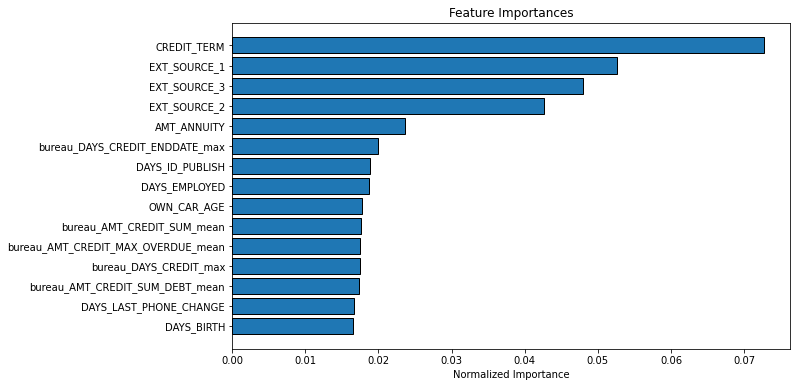

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv(path + 'lgb_before_scaling.csv',index = False)

In [ ]:
submission_scaled, fi_scaled , metrics_scaled  = model(train_corrs_removed , test_corrs_removed,scaling = True )


Training Data Shape:  (252136, 322)
Testing Data Shape:  (48744, 322)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.817307	train's binary_logloss: 0.529019	valid's auc: 0.771975	valid's binary_logloss: 0.547241
Early stopping, best iteration is:
[291]	train's auc: 0.834936	train's binary_logloss: 0.510434	valid's auc: 0.772985	valid's binary_logloss: 0.535721
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.817339	train's binary_logloss: 0.529117	valid's auc: 0.773569	valid's binary_logloss: 0.552226
Early stopping, best iteration is:
[265]	train's auc: 0.830217	train's binary_logloss: 0.515738	valid's auc: 0.773912	valid's binary_logloss: 0.54394
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.817343	train's binary_logloss: 0.528793	valid's auc: 0.766289	valid's binary_logloss: 0.550447
[400]	train's auc: 0.853127	train's binary_logloss: 0.490797	valid's auc: 0.766253	valid's b

In [ ]:
metrics_scaled

,fold,train,valid
0,0,0.83494,0.77299
1,1,0.83022,0.77391
2,2,0.84171,0.76722
3,3,0.82783,0.77095
4,4,0.82020,0.76928
5,overall,0.83098,0.77086


In [ ]:
submission_scaled.to_csv(path  +  'lgb_after_scale.csv',index = False)

In [ ]:
submission_scaled.head()

,SK_ID_CURR,TARGET
0,100001,0.24155
1,100005,0.79386
2,100013,0.30603
3,100028,0.58288
4,100038,0.74465


Usually we will normalize or scaling before  feature  selection  but it's not a goldent rule in this case  the  above submission  csv after scaling to kaggle got  score : 0.72188 this score is less than before scaling . (0.76946 )
I thought that scaling reduce  range of number so it reduce difference between each value in it own feature therefore it may make model  didn't classified well .

In [ ]:
submission_imputed, fi_imputed, metrics_imputed  = model(train_corrs_removed , test_corrs_removed,impute = True )


Training Data Shape:  (252136, 322)
Testing Data Shape:  (48744, 322)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.815482	train's binary_logloss: 0.530997	valid's auc: 0.771124	valid's binary_logloss: 0.549061
[400]	train's auc: 0.849852	train's binary_logloss: 0.494702	valid's auc: 0.771745	valid's binary_logloss: 0.526884
Early stopping, best iteration is:
[361]	train's auc: 0.843792	train's binary_logloss: 0.50112	valid's auc: 0.771972	valid's binary_logloss: 0.530841
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.815843	train's binary_logloss: 0.53098	valid's auc: 0.773372	valid's binary_logloss: 0.553229
[400]	train's auc: 0.850093	train's binary_logloss: 0.495014	valid's auc: 0.773746	valid's binary_logloss: 0.531113
Early stopping, best iteration is:
[334]	train's auc: 0.840168	train's binary_logloss: 0.505563	valid's auc: 0.774315	valid's binary_logloss: 0.537588
Training until validation scores don't i

In [ ]:
metrics_imputed 

,fold,train,valid
0,0,0.84379,0.77197
1,1,0.84017,0.77431
2,2,0.82399,0.76661
3,3,0.82713,0.77070
4,4,0.83714,0.76929
5,overall,0.83444,0.77062


In [ ]:
submission_imputed.to_csv(path + 'imputed_feat_lgb.csv',index= False)

this submission score is 0.76720

Due to we have imbalance class problem so some choices of solution I think of is over-sampling and under-sampling . 

Two of these have pros and cons and because  we don't have a ton of data so I'll choose over-sampling .

The over-sampling technique I'll use call SMOTE (Synthetic Minority Oversampling Technique)
This technique generates synthetic data for the minority class.

SMOTE  works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.




The over-sampling technique I'll use call SMOTE (Synthetic Minority Oversampling Technique)
This technique generates synthetic data for the minority class.

SMOTE  works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.




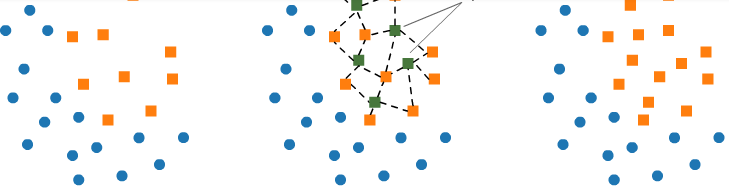

SMOTE algorithm works in 4 simple steps:

1.Choose a minority class as the input vector

2.Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)

3.Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
4.Repeat the steps until data is balanced

so I have to edit some process in function . 

In [ ]:
def smote_then_model(features, test_features, encoding = 'ohe', n_folds = 5,scaling = False,impute = False ):
    

    smote = SMOTE()
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        scaler = StandardScaler()
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
       
        if scaling : 
          scaler.fit(train_features)
          train_features = scaler.transform(train_features)
          valid_features =  scaler.transform(valid_features)
          test_features = scaler.transform(test_features)
        if impute  : 
          imputer = SimpleImputer(strategy= 'most_frequent') # due to our dataset has many skew data so we will use most frequent to impute
          imputer.fit(train_features)
          train_features = imputer.transform(train_features)
          valid_features =  imputer.transform(valid_features)
          test_features = imputer.transform(test_features)
        #smote 
        train_features,train_labels = smote.fit_resample(train_features, train_labels)
        # Create the model
       
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
submission_smoted, fi_sm, metrics_sm  = smote_then_model(train_corrs_removed , test_corrs_removed,impute = True )


Training Data Shape:  (252136, 322)
Testing Data Shape:  (48744, 322)
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.980542	train's binary_logloss: 0.137821	valid's auc: 0.767241	valid's binary_logloss: 0.253336
[400]	train's auc: 0.984845	train's binary_logloss: 0.127649	valid's auc: 0.772468	valid's binary_logloss: 0.251319
Early stopping, best iteration is:
[389]	train's auc: 0.984667	train's binary_logloss: 0.128069	valid's auc: 0.772572	valid's binary_logloss: 0.251279
Training until validation scores don't improve for 100 rounds.
[200]	train's auc: 0.980821	train's binary_logloss: 0.13648	valid's auc: 0.768517	valid's binary_logloss: 0.260886
[400]	train's auc: 0.985186	train's binary_logloss: 0.126225	valid's auc: 0.773517	valid's binary_logloss: 0.258969
[600]	train's auc: 0.988107	train's binary_logloss: 0.118965	valid's auc: 0.774253	valid's binary_logloss: 0.258692
Early stopping, best iteration is:
[636]	train's auc: 0.98857	train's bina

In [ ]:
metrics_sm

,fold,train,valid
0,0,0.98467,0.77257
1,1,0.98857,0.77445
2,2,0.98506,0.76730
3,3,0.98685,0.77245
4,4,0.98507,0.77054
5,overall,0.98604,0.77144


we see that high auc in training set but low on validation set . it's overfitting.  

there is problem with smote that  If there are observations in the minority class which are outlying and appears in the majority class, it causes a problem for SMOTE, by creating a line bridge with the majority class that lead to overfitting but the borderline smote(similar to  DBSCAN concept)  will solve this let's edit this model function again.

In [ ]:
def blsmote_then_model(features, test_features, encoding = 'ohe', n_folds = 5,scaling = False,impute = False ):
    

    smote = BorderlineSMOTE()
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        scaler = StandardScaler()
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
       
        if scaling : 
          scaler.fit(train_features)
          train_features = scaler.transform(train_features)
          valid_features =  scaler.transform(valid_features)
          test_features = scaler.transform(test_features)
        if impute  : 
          imputer = SimpleImputer(strategy= 'most_frequent') # due to our dataset has many skew data so we will use most frequent to impute
          imputer.fit(train_features)
          train_features = imputer.transform(train_features)
          valid_features =  imputer.transform(valid_features)
          test_features = imputer.transform(test_features)
        #smote 
        train_features,train_labels = smote.fit_resample(train_features, train_labels)
        # Create the model
       
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 1, reg_lambda = 1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [ ]:
submission_smoted, fi_sm, metrics_sm  = blsmote_then_model(train_corrs_removed , test_corrs_removed,impute = True )


Training Data Shape:  (252136, 322)
Testing Data Shape:  (48744, 322)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.138075	train's auc: 0.980288	valid's binary_logloss: 0.253237	valid's auc: 0.767265
[400]	train's binary_logloss: 0.129017	train's auc: 0.983866	valid's binary_logloss: 0.250932	valid's auc: 0.773337
Early stopping, best iteration is:
[486]	train's binary_logloss: 0.126156	train's auc: 0.985066	valid's binary_logloss: 0.250763	valid's auc: 0.773764
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.13664	train's auc: 0.980562	valid's binary_logloss: 0.260518	valid's auc: 0.77002
[400]	train's binary_logloss: 0.127667	train's auc: 0.984159	valid's binary_logloss: 0.25857	valid's auc: 0.774936
[600]	train's binary_logloss: 0.12123	train's auc: 0.986809	valid's binary_logloss: 0.258231	valid's auc: 0.77595
[800]	train's binary_logloss: 0.115662	train's auc: 0.988956	valid's binary_lo

In [ ]:
metrics_sm

,fold,train,valid
0,0,0.98507,0.77376
1,1,0.98852,0.77691
2,2,0.98617,0.76835
3,3,0.98492,0.77280
4,4,0.98445,0.77220
5,overall,0.98583,0.77279


In [ ]:
submission_smoted.head()

,SK_ID_CURR,TARGET
0,100001,0.02876
1,100005,0.17231
2,100013,0.01327
3,100028,0.03677
4,100038,0.18980


In [ ]:
submission_smoted.to_csv(path + 'bl_smote_lgb.csv',index = False )

After use borderline smote and some regulization it still overfit but score of submission is a bit better 0.77085

Let's try other model 

In [3]:
train_corrs_removed = pd.read_csv(path + 'train_corrs_removed.csv')
test_corrs_removed = pd.read_csv(path + 'test_corrs_removed.csv')


In [4]:
imputer = SimpleImputer(strategy = 'most_frequent')
scaler = StandardScaler()
smote = BorderlineSMOTE()
train  =  train_corrs_removed.copy()
test = test_corrs_removed.copy()
train_id = train['SK_ID_CURR']
test_id = test['SK_ID_CURR']
labels = train['TARGET']
train.drop(columns = ['SK_ID_CURR', 'TARGET'],inplace =True)
test.drop(columns = ['SK_ID_CURR'],inplace = True)
print(train.shape)
print(test.shape)
train_col = list(train.columns)
test_col = list(test.columns)
print(x for x in train_col if x not in test_col)
train =  pd.get_dummies(train)
test = pd.get_dummies(test)
train , test =  train.align(test,join = 'inner',axis  =1)
print(train.shape)
print(test.shape)
X_train , X_val ,y_train  , y_val = train_test_split(train,labels ,test_size= 0.2 , random_state=  42)
imputer.fit(X_train)
X_train = imputer.transform(X_train)
X_val = imputer.transform(X_val)
test  = imputer.transform(test)
X_train ,y_train  =  smote.fit_resample(X_train,y_train)
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
test  = scaler.transform(test)






(252136, 205)
(48744, 205)
<generator object <genexpr> at 0x7fb4bb7cdf50>
(252136, 324)
(48744, 324)


In [ ]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)
log_pred=  log_reg.predict(X_val)

In [ ]:
log_auc = roc_auc_score(y_val,log_pred)
log_auc

0.6856520968824527

In [ ]:
log_pred_test  = log_reg.predict_proba(test)

In [ ]:
train_corrs_removed.to_csv(path  +'train_corrs_removed.csv')
test_corrs_removed.to_csv(path  +'test_corrs_removed.csv')


In [ ]:
xgb_cl =  xgb.XGBRFClassifier()
xgb_cl.fit(X_train, y_train)
xgb_pred =  xgb_cl.predict(X_val)
xgb_auc = roc_auc_score(y_val,xgb_pred)
xgb_auc

0.5515608716543464

In [ ]:
rf= RandomForestClassifier(n_estimators=100 ,random_state =50 , verbose =1 ,n_jobs= -1)
rf.fit(X_train,y_train)
rf_pred = rf.predict(X_val)
rf_auc = roc_auc_score(y_val,rf_pred)
rf_auc

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    2.0s finished


0.5002285191956124

In [5]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
svm = CalibratedClassifierCV(LinearSVC())
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_val)
svm_auc = roc_auc_score(y_val,svm_pred)
svm_auc

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


0.6858718329855561

In [58]:
def blsmote_then_model_reg3(features, test_features, encoding = 'ohe', n_folds = 5,scaling = False,impute = False ):
    

    smote = BorderlineSMOTE()
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        scaler = StandardScaler()
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
       
        if scaling : 
          scaler.fit(train_features)
          train_features = scaler.transform(train_features)
          valid_features =  scaler.transform(valid_features)
          test_features = scaler.transform(test_features)
        if impute  : 
          imputer = SimpleImputer(strategy= 'most_frequent') # due to our dataset has many skew data so we will use most frequent to impute
          imputer.fit(train_features)
          train_features = imputer.transform(train_features)
          valid_features =  imputer.transform(valid_features)
          test_features = imputer.transform(test_features)
        #smote 
        train_features,train_labels = smote.fit_resample(train_features, train_labels)
        # Create the model
       
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 3, reg_lambda = 3, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [59]:
submission_smoted3, fi_sm3, metrics_sm3  = blsmote_then_model_reg3(train_corrs_removed , test_corrs_removed,impute = True )


Training Data Shape:  (252136, 322)
Testing Data Shape:  (48744, 322)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.138259	train's auc: 0.980163	valid's binary_logloss: 0.253086	valid's auc: 0.76769
[400]	train's binary_logloss: 0.129989	train's auc: 0.983244	valid's binary_logloss: 0.250802	valid's auc: 0.773511
[600]	train's binary_logloss: 0.124508	train's auc: 0.985522	valid's binary_logloss: 0.250522	valid's auc: 0.774078
[800]	train's binary_logloss: 0.119629	train's auc: 0.987518	valid's binary_logloss: 0.250432	valid's auc: 0.774458
Early stopping, best iteration is:
[740]	train's binary_logloss: 0.12103	train's auc: 0.986961	valid's binary_logloss: 0.250363	valid's auc: 0.774587
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.137011	train's auc: 0.980406	valid's binary_logloss: 0.260506	valid's auc: 0.769603
[400]	train's binary_logloss: 0.128612	train's auc: 0.98354	valid's binary_

In [60]:
metrics_sm3

,fold,train,valid
0,0,0.98696,0.77459
1,1,0.98438,0.77674
2,2,0.98466,0.77080
3,3,0.98418,0.77492
4,4,0.98449,0.77413
5,overall,0.98494,0.77425


In [62]:
submission_smoted3.to_csv(path + 'lgb_more_reg.csv',index = False)

In [4]:
def blsmote_then_model_reg5(features, test_features, encoding = 'ohe', n_folds = 5,scaling = False,impute = False ):
    

    smote = BorderlineSMOTE()
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        scaler = StandardScaler()
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
       
        if scaling : 
          scaler.fit(train_features)
          train_features = scaler.transform(train_features)
          valid_features =  scaler.transform(valid_features)
          test_features = scaler.transform(test_features)
        if impute  : 
          imputer = SimpleImputer(strategy= 'most_frequent') # due to our dataset has many skew data so we will use most frequent to impute
          imputer.fit(train_features)
          train_features = imputer.transform(train_features)
          valid_features =  imputer.transform(valid_features)
          test_features = imputer.transform(test_features)
        #smote 
        train_features,train_labels = smote.fit_resample(train_features, train_labels)
        # Create the model
       
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha =10, reg_lambda = 10, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [7]:
submission_smoted10, fi_sm10, metrics_sm10  = blsmote_then_model_reg5(train_corrs_removed , test_corrs_removed,impute = True)


Training Data Shape:  (252136, 324)
Testing Data Shape:  (48744, 324)
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.139307	train's auc: 0.979898	valid's binary_logloss: 0.253548	valid's auc: 0.766668
[400]	train's binary_logloss: 0.131426	train's auc: 0.982619	valid's binary_logloss: 0.250334	valid's auc: 0.774456
[600]	train's binary_logloss: 0.127146	train's auc: 0.984392	valid's binary_logloss: 0.249964	valid's auc: 0.775289
Early stopping, best iteration is:
[588]	train's binary_logloss: 0.127362	train's auc: 0.984301	valid's binary_logloss: 0.249952	valid's auc: 0.775328
Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.137942	train's auc: 0.980143	valid's binary_logloss: 0.2611	valid's auc: 0.767908
[400]	train's binary_logloss: 0.130423	train's auc: 0.982722	valid's binary_logloss: 0.258018	valid's auc: 0.775593
[600]	train's binary_logloss: 0.126115	train's auc: 0.984522	valid's binary

In [8]:
metrics_sm10

,fold,train,valid
0,0,0.98430,0.77533
1,1,0.98498,0.77706
2,2,0.98632,0.77175
3,3,0.98340,0.77458
4,4,0.98316,0.77434
5,overall,0.98443,0.77458
